In [1]:
import sys
import os
import numpy as np
from pathlib import Path
import cv2 as cv
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from unet.unet_transfer import UNet16, input_size
import matplotlib.pyplot as plt
from matplotlib.image import imread
import argparse
from os.path import join
from PIL import Image
import gc
from utils import load_unet_vgg16, load_unet_resnet_101, load_unet_resnet_34
from tqdm import tqdm

def evaluate_img(model, img):
    input_width, input_height = input_size[0], input_size[1]

    img_1 = cv.resize(img, (input_width, input_height), cv.INTER_AREA)
    X = train_tfms(Image.fromarray(img_1))
    X = Variable(X.unsqueeze(0)).cuda()  # [N, 1, H, W]

    mask = model(X)

    mask = F.sigmoid(mask[0, 0]).data.cpu().numpy()
    mask = cv.resize(mask, (img_width, img_height), cv.INTER_AREA)
    return mask

def evaluate_img_patch(model, img):
    input_width, input_height = input_size[0], input_size[1]

    img_height, img_width, img_channels = img.shape

    if img_width < input_width or img_height < input_height:
        return evaluate_img(model, img)

    stride_ratio = 0.1
    stride = int(input_width * stride_ratio)

    normalization_map = np.zeros((img_height, img_width), dtype=np.int16)

    patches = []
    patch_locs = []
    for y in range(0, img_height - input_height + 1, stride):
        for x in range(0, img_width - input_width + 1, stride):
            segment = img[y:y + input_height, x:x + input_width]
            normalization_map[y:y + input_height, x:x + input_width] += 1
            patches.append(segment)
            patch_locs.append((x, y))

    patches = np.array(patches)
    if len(patch_locs) <= 0:
        return None

    preds = []
    for i, patch in enumerate(patches):
        patch_n = train_tfms(Image.fromarray(patch))
        X = Variable(patch_n.unsqueeze(0)).cuda()  # [N, 1, H, W]
        masks_pred = model(X)
        mask = F.sigmoid(masks_pred[0, 0]).data.cpu().numpy()
        preds.append(mask)

    probability_map = np.zeros((img_height, img_width), dtype=float)
    for i, response in enumerate(preds):
        coords = patch_locs[i]
        probability_map[coords[1]:coords[1] + input_height, coords[0]:coords[0] + input_width] += response

    return probability_map

In [2]:
model_path = 'models/exp25/model_best.pt'
model = load_unet_vgg16(model_path)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


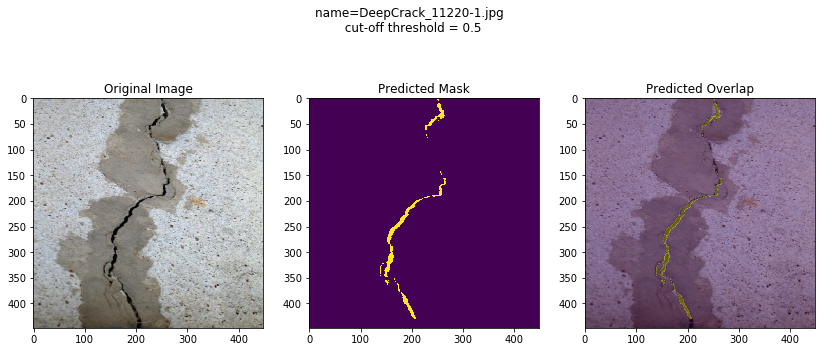

In [3]:
# image_path = 'custom_image/test_brickwall.jpg'
# image_path = '/home/jovyan/work/hangman/dataset/crack_segmentation_dataset/minimal_06/test/images/cvt_0028_DeepCrack_11258-1.jpg'
image_path = '/home/jovyan/work/hangman/dataset/crack_segmentation_dataset/images/DeepCrack_11220-1.jpg'
channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.225]


train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(channel_means, channel_stds)])
img_0 = Image.open(image_path)
img_0 = np.asarray(img_0)
if len(img_0.shape) != 3:
    print(f'incorrect image shape: {image_path.name}{img_0.shape}')
img_0 = img_0[:,:,:3]

img_height, img_width, img_channels = img_0.shape
prob_map_full = evaluate_img(model, img_0)


if img_0.shape[0] > 2000 or img_0.shape[1] > 2000:
    img_1 = cv.resize(img_0, None, fx=0.2, fy=0.2, interpolation=cv.INTER_AREA)
else:
    img_1 = img_0

prob_map_patch = evaluate_img_patch(model, img_1)

prob_map_viz_patch = prob_map_patch.copy()

prob_map_viz_patch = np.where(prob_map_viz_patch<0.99999, 0, 1)
fig = plt.figure(figsize=(14,6))
st = fig.suptitle(f'name={os.path.basename(image_path)} \n cut-off threshold = {0.5}', fontsize="large")
ax1 = fig.add_subplot(131)
ax1.title.set_text('Original Image')
# ax1.axis('off')
ax1.imshow(img_1)
ax2 = fig.add_subplot(132)
ax2.title.set_text('Predicted Mask')
# ax2.axis('off')
ax2.imshow(prob_map_viz_patch)
ax3 = fig.add_subplot(133)
ax3.title.set_text('Predicted Overlap')
# ax3.axis('off')
ax3.imshow(img_1)
ax3.imshow(prob_map_viz_patch, alpha=0.4)